## Constants

In [1]:
DEFAULT = 'DEFAULT'

## Utils

In [2]:
from collections import UserList

class IdComparableList(UserList):
    def __init__(self, lst):
        self.data = lst

    def __contains__(self, obj):
        """Return True if any item'm identifier matches that of the passed-in dict"""
        return any(obj.identifier == x.identifier for x in self.data)

class TripleIdComparableList(UserList):
    def __init__(self, lst):
        self.data = lst

    def __contains__(self, obj):
        """Return True if any item'm identifier matches that of the passed-in dict"""
        return any(obj.identifier == x.identifier and obj.node_from.identifier == x.node_from.identifier and obj.node_to.identifier == x.node_to.identifier for x in self.data)

## CLARSM

In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict 

class SemanticMemory():
    def __init__(self, memory_depth, memory_width):
        self.memory_depth = memory_depth
        self.memory_width = memory_width
        self.nodes = IdComparableList([])
        self.actions = IdComparableList([])
        self.interactions = TripleIdComparableList([])

    def __str__(self):
        memory_dump = "Nodes: " + "\n"
        for node in self.nodes:
            memory_dump += "  -" + str(node) + "\n"
        memory_dump += "Interactions: " + "\n"
        for interaction in self.interactions:
            memory_dump += "  -" + str(interaction) + "\n"
        memory_dump += "Actions: " + "\n"
        for action in self.actions:
            memory_dump += "  -" + str(action) + "\n"
        
        return memory_dump

    def finish_cycle(self):
        for node in self.nodes:
            node.finish_cycle()
    
    def recognize(self, recognized):
        if isinstance(recognized, Action):
            if recognized not in self.actions:
                self.actions.append(recognized)
        else:
            if recognized not in self.nodes:
                self.nodes.append(recognized)
            [x for x in self.nodes if x.identifier == recognized.identifier][0].time_to_activation = self.memory_width
    
    def fasten(self, node_from, node_to, interaction_id):
        interaction = Interaction(interaction_id, node_from, node_to)
        
        if isinstance(node_from, Action):
            [x for x in self.actions if x.identifier == node_from.identifier][0].fasten(node_to, interaction)
        else:
            [x for x in self.nodes if x.identifier == node_from.identifier][0].fasten(node_to, interaction)
        if isinstance(node_to, Action):
            [x for x in self.actions if x.identifier == node_to.identifier][0].fasten(node_from, interaction)
        else:
            [x for x in self.nodes if x.identifier == node_to.identifier][0].fasten(node_from, interaction)
        
        if interaction not in self.interactions:
            self.interactions.append(Interaction(interaction_id, node_from, node_to))

    def extract(self):
        extracted_subgraph = set()
        
        for node in self.nodes:
            if not isinstance(node, Action) and node.time_to_activation > 0:
                extracted_subgraph = extracted_subgraph.union(self.extract_nodes(node, self.memory_depth))
        
        nodes_for_interactions = defaultdict(empty_interaction_data)
        
        for node in extracted_subgraph:
            interaction_ids = node.get_interaction_ids()
            
            for interaction_id in interaction_ids:
                nodes_for_interactions[interaction_id].add_node(node)
        
        cleaned_nodes_for_interactions = dict()
        
        for interaction in nodes_for_interactions.keys():
            if (nodes_for_interactions[interaction].is_complete()):
                cleaned_nodes_for_interactions[interaction] = nodes_for_interactions[interaction]
                
        extracted_submemory_list = []
        interaction_indices = cleaned_nodes_for_interactions.keys()
        all_columns = ["name", "taste", "price", "container", "health", "action"]
        feature_columns = ["name", "taste", "price", "container", "health"]
        action_column = ["action"]
        for interaction in cleaned_nodes_for_interactions.keys():
            extracted_submemory_list.append(cleaned_nodes_for_interactions[interaction].transform())     
            
        if not cleaned_nodes_for_interactions:
            return (None, None)
            
        extracted_submemory = np.array(extracted_submemory_list)
        extracted_submemory_dataframe = pd.DataFrame(data=extracted_submemory, index=interaction_indices, columns=all_columns)
        
        return (extracted_submemory_dataframe[feature_columns], extracted_submemory_dataframe[action_column])

    def extract_nodes(self, starting_node, depth):
        extracted_nodes = {starting_node}
        
        if depth > 0 and not isinstance(starting_node, Action):
            for fastened_node in starting_node.fastened_nodes:
                extracted_nodes = extracted_nodes.union(self.extract_nodes(fastened_node, depth - 1))
        return extracted_nodes
    
class Node():
    def __init__(self, identifier):
        self.identifier = identifier
        self.time_to_activation = 0
        self.fastened_nodes = IdComparableList([])
        self.interactions = IdComparableList([])

    def finish_cycle(self):
        if (self.time_to_activation > 0):
            self.time_to_activation -= 1
    
    def fasten(self, node_to, interaction_id):
        if interaction_id not in self.interactions:
            self.interactions.append(interaction_id)
        
        if node_to not in self.fastened_nodes:
            self.fastened_nodes.append(node_to)
            
    def get_interaction_ids(self):
        return [x.identifier for x in self.interactions]

class Interaction():
    def __init__(self, identifier, node_from, node_to):
        self.identifier = identifier
        self.node_from = node_from
        self.node_to = node_to
    
    def __str__(self):
        return 'Interaction {self.identifier} from {self.node_from.identifier} to {self.node_to.identifier}.'.format(self=self)

class Action():
    def __init__(self, identifier, name):
        self.identifier = identifier
        self.name = name
        self.interaction_ids = []
    
    def __str__(self):
        return 'Action {self.name} with id {self.identifier}.'.format(self=self)

    def fasten(self, node_to, interaction_id):
        self.interaction_ids.append(interaction_id)
        
    def get_interaction_ids(self):
        return [x.identifier for x in self.interaction_ids]

class Worker(Node):
    def __init__(self, identifier, name):
        super().__init__(identifier)
        self.name = name

    def __str__(self):
        description = "Worker node named {self.name} with id {self.identifier}".format(self=self)
        
        for node in self.fastened_nodes:
            description += ' connected with {self.identifier}'.format(self=node)
        
        description += "."
        
        if (self.time_to_activation > 0):
            description += " [Activated]"
        
        return description

class Drink(Node):
    def __init__(self, identifier, name, taste, price, container):
        super().__init__(identifier)
        self.name = name
        self.taste = taste
        self.price = price
        self.container = container

    def __str__(self):
        description = "Drink node named {self.name} with {self.taste} taste, {self.price} price and in {self.container} container with id {self.identifier}".format(self=self)
        
        for node in self.fastened_nodes:
            description += ' connected with {self.identifier}'.format(self=node)
        
        description += "."
        
        if (self.time_to_activation > 0):
            description += " [Activated]"
        
        return description

class Health(Node):
    def __init__(self, identifier, state):
        super().__init__(identifier)
        self.state = state

    def __str__(self):
        description = "Health condition with {self.state} state ".format(self=self)
        
        for node in self.fastened_nodes:
            description += ' connected with {self.identifier} '.format(self=node)
        
        description += "."
        
        if (self.time_to_activation > 0):
            description += " [Activated]"
        
        return description

class InteractionData():
    def __init__(self):
        self.action = Action(DEFAULT, DEFAULT)
        self.worker = Worker(DEFAULT, DEFAULT)
        self.drink = Drink(DEFAULT, DEFAULT, DEFAULT, DEFAULT, DEFAULT)
        self.health = Health(DEFAULT, DEFAULT)
    
    def add_node(self, node):
        if isinstance(node, Action):
            self.action = node
        elif isinstance(node, Worker):
            self.worker = node
        elif isinstance(node, Drink):
            self.drink = node
        elif isinstance(node, Health):
            self.health = node
    
    def is_complete(self):
        return self.action.identifier != DEFAULT
    
    def transform(self):
        return [self.worker.name, self.drink.taste, self.drink.price, self.drink.container, self.health.state, self.action.name]
    
    def __str__(self):
        description = "["
        
        for x in self.transform():
            description += str(x) + " "
        
        description += "]"
        
        return description
    
def empty_interaction_data():
    return InteractionData()

### SciKit OHE

In [4]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd 

def ohe(X, y):
    ohe = OneHotEncoder()

    ohe.fit(X)
    X_ohe = ohe.transform(X).toarray()
    y_ravel = np.ravel(y)

    return (X_ohe, y_ravel, pd.DataFrame(X_ohe, columns=ohe.get_feature_names(X.columns)))

## Experiments

In [5]:
def init_semantic_memory(memory_depth, memory_width, printing=False):
    semantic_memory = SemanticMemory(memory_depth, memory_width)
    
    # Interaction 001 Mark: I love coke! I just need one to start a day (Pass Coke)
    if printing:
        print("Interaction 001 Mark: I love coke! I just need one to start a day (Pass Coke)")
    interaction_id = "interaction_001"
    worker = Worker("Node_001", "Mark")
    drink = Drink("Node_002", "Coke", "sweet", 4, "can")
    health = Health("Node_003", "Healthy")
    action = Action("Action_01", "Pass Coke")

    semantic_memory.recognize(worker)
    semantic_memory.recognize(drink)
    semantic_memory.recognize(health)
    semantic_memory.recognize(action)
    semantic_memory.fasten(worker, drink, interaction_id)
    semantic_memory.fasten(worker, health, interaction_id)
    semantic_memory.fasten(action, drink, interaction_id)

    if printing:
        print(semantic_memory)
    semantic_memory.finish_cycle()
    
    # Interaction 002 Mark: A need something else sweet, maybe juice? (Pass Juice)
    if printing:
        print("Interaction 002 Mark: A need something else sweet, maybe juice? (Pass Juice)")
    interaction_id = "interaction_002"
    worker = Worker("Node_001", "Mark")
    drink = Drink("Node_004", "Juice", "sweet", 2, "bootle")
    health = Health("Node_003", "Healthy")
    action = Action("Action_02", "Pass Juice")

    semantic_memory.recognize(worker)
    semantic_memory.recognize(drink)
    semantic_memory.recognize(health)
    semantic_memory.recognize(action)
    semantic_memory.fasten(worker, drink, interaction_id)
    semantic_memory.fasten(worker, health, interaction_id)
    semantic_memory.fasten(action, drink, interaction_id)
    
    if printing:
        print(semantic_memory)
    semantic_memory.finish_cycle()
    
    # Interaction 003 Susan: I would like to get one bottle of water. (Pass Water)
    if printing:
        print("Interaction 003 Susan: I would like to get one bottle of water. (Pass Water)")
    interaction_id = "interaction_003"
    worker = Worker("Node_005", "Susan")
    drink = Drink("Node_006", "Water", "neutral", 2, "bootle")
    health = Health("Node_003", "Healthy")
    action = Action("Action_03", "Pass Water")

    semantic_memory.recognize(worker)
    semantic_memory.recognize(drink)
    semantic_memory.recognize(health)
    semantic_memory.recognize(action)
    semantic_memory.fasten(worker, drink, interaction_id)
    semantic_memory.fasten(worker, health, interaction_id)
    semantic_memory.fasten(action, drink, interaction_id)

    if printing:
        print(semantic_memory)
    semantic_memory.finish_cycle()
    
    # Interaction 004 Martin: I used to drink a lot of coke and I love it, but with my diabetics I started to drink more and more water (Pass Water)
    if printing:
        print("Interaction 004 Martin: I used to drink a lot of coke and I love it, but with my diabetics I started to drink more and more water (Pass Water)")
    interaction_id = "interaction_004"
    worker = Worker("Node_007", "Martin")
    drink = Drink("Node_006", "Water", "neutral", 2, "bootle")
    health = Health("Node_008", "Diabetic")
    action = Action("Action_03", "Pass Water")

    semantic_memory.recognize(worker)
    semantic_memory.recognize(drink)
    semantic_memory.recognize(health)
    semantic_memory.recognize(action)
    semantic_memory.fasten(worker, drink, interaction_id)
    semantic_memory.fasten(worker, health, interaction_id)
    semantic_memory.fasten(action, drink, interaction_id)

    if printing:
        print(semantic_memory)
    semantic_memory.finish_cycle()
    
    return semantic_memory

### Mark, depth = 2, width = 1 with printing

In [6]:
semantic_memory = init_semantic_memory(2, 1, True)

Interaction 001 Mark: I love coke! I just need one to start a day (Pass Coke)
Nodes: 
  -Worker node named Mark with id Node_001 connected with Node_002 connected with Node_003. [Activated]
  -Drink node named Coke with sweet taste, 4 price and in can container with id Node_002 connected with Node_001 connected with Action_01. [Activated]
  -Health condition with Healthy state  connected with Node_001 . [Activated]
Interactions: 
  -Interaction interaction_001 from Node_001 to Node_002.
  -Interaction interaction_001 from Node_001 to Node_003.
  -Interaction interaction_001 from Action_01 to Node_002.
Actions: 
  -Action Pass Coke with id Action_01.

Interaction 002 Mark: A need something else sweet, maybe juice? (Pass Juice)
Nodes: 
  -Worker node named Mark with id Node_001 connected with Node_002 connected with Node_003 connected with Node_004. [Activated]
  -Drink node named Coke with sweet taste, 4 price and in can container with id Node_002 connected with Node_001 connected with 

In [7]:
print(semantic_memory)

Nodes: 
  -Worker node named Mark with id Node_001 connected with Node_002 connected with Node_003 connected with Node_004.
  -Drink node named Coke with sweet taste, 4 price and in can container with id Node_002 connected with Node_001 connected with Action_01.
  -Health condition with Healthy state  connected with Node_001  connected with Node_005 .
  -Drink node named Juice with sweet taste, 2 price and in bootle container with id Node_004 connected with Node_001 connected with Action_02.
  -Worker node named Susan with id Node_005 connected with Node_006 connected with Node_003.
  -Drink node named Water with neutral taste, 2 price and in bootle container with id Node_006 connected with Node_005 connected with Action_03 connected with Node_007.
  -Worker node named Martin with id Node_007 connected with Node_006 connected with Node_008.
  -Health condition with Diabetic state  connected with Node_007 .
Interactions: 
  -Interaction interaction_001 from Node_001 to Node_002.
  -Inte

In [8]:
# Interaction 005 Mark: What can you offer? 

worker = Worker("Node_001", "Mark")
semantic_memory.recognize(worker)

print(semantic_memory)

X, y = semantic_memory.extract()

semantic_memory.finish_cycle()

Nodes: 
  -Worker node named Mark with id Node_001 connected with Node_002 connected with Node_003 connected with Node_004. [Activated]
  -Drink node named Coke with sweet taste, 4 price and in can container with id Node_002 connected with Node_001 connected with Action_01.
  -Health condition with Healthy state  connected with Node_001  connected with Node_005 .
  -Drink node named Juice with sweet taste, 2 price and in bootle container with id Node_004 connected with Node_001 connected with Action_02.
  -Worker node named Susan with id Node_005 connected with Node_006 connected with Node_003.
  -Drink node named Water with neutral taste, 2 price and in bootle container with id Node_006 connected with Node_005 connected with Action_03 connected with Node_007.
  -Worker node named Martin with id Node_007 connected with Node_006 connected with Node_008.
  -Health condition with Diabetic state  connected with Node_007 .
Interactions: 
  -Interaction interaction_001 from Node_001 to Node_

In [9]:
X

name  taste price container   health
interaction_001  Mark  sweet     4       can  Healthy
interaction_002  Mark  sweet     2    bootle  Healthy

In [10]:
y

action
interaction_001   Pass Coke
interaction_002  Pass Juice

In [11]:
X_ohe, y_ravel, X_ohe_df = ohe(X, y)
X_ohe_df

name_Mark  taste_sweet  price_2  price_4  container_bootle  container_can  \
0        1.0          1.0      0.0      1.0               0.0            1.0   
1        1.0          1.0      1.0      0.0               1.0            0.0   

   health_Healthy  
0             1.0  
1             1.0

In [12]:
X_predict = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
X_predict

array([[1., 0., 0., 0., 0., 0., 0.]])

['Pass Coke' 'Pass Juice']
['Pass Coke']


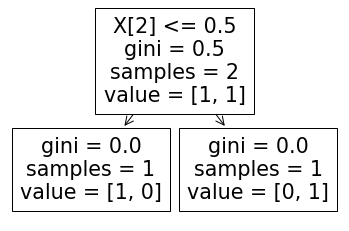

In [13]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_ohe, y_ravel)
tree.plot_tree(clf)
print(clf.predict(X_ohe[0:X.shape[0]]))
print(clf.predict(X_predict))

In [14]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_ohe, y_ravel)
MultinomialNB()
print(clf.predict(X_ohe[0:X.shape[0]]))
print(clf.predict(X_predict))

['Pass Coke' 'Pass Juice']
['Pass Coke']


In [15]:
from sklearn.naive_bayes import CategoricalNB

clf = CategoricalNB()
clf.fit(X_ohe, y_ravel)
MultinomialNB()
print(clf.predict(X_ohe[0:X.shape[0]]))
print(clf.predict(X_predict))

['Pass Coke' 'Pass Juice']
['Pass Coke']


### Mark, depth = 2, width = 5

In [16]:
semantic_memory = init_semantic_memory(2, 5)

In [17]:
# Interaction 005 Mark: What can you offer? 

worker = Worker("Node_001", "Mark")
semantic_memory.recognize(worker)

X, y = semantic_memory.extract()
print(semantic_memory)

semantic_memory.finish_cycle()

Nodes: 
  -Worker node named Mark with id Node_001 connected with Node_002 connected with Node_003 connected with Node_004. [Activated]
  -Drink node named Coke with sweet taste, 4 price and in can container with id Node_002 connected with Node_001 connected with Action_01. [Activated]
  -Health condition with Healthy state  connected with Node_001  connected with Node_005 . [Activated]
  -Drink node named Juice with sweet taste, 2 price and in bootle container with id Node_004 connected with Node_001 connected with Action_02. [Activated]
  -Worker node named Susan with id Node_005 connected with Node_006 connected with Node_003. [Activated]
  -Drink node named Water with neutral taste, 2 price and in bootle container with id Node_006 connected with Node_005 connected with Action_03 connected with Node_007. [Activated]
  -Worker node named Martin with id Node_007 connected with Node_006 connected with Node_008. [Activated]
  -Health condition with Diabetic state  connected with Node_00

In [18]:
X

name    taste price container    health
interaction_004  Martin  neutral     2    bootle  Diabetic
interaction_003   Susan  neutral     2    bootle   Healthy
interaction_002    Mark    sweet     2    bootle   Healthy
interaction_001    Mark    sweet     4       can   Healthy

In [19]:
y

action
interaction_004  Pass Water
interaction_003  Pass Water
interaction_002  Pass Juice
interaction_001   Pass Coke

In [20]:
X_ohe, y_ravel, X_ohe_df = ohe(X, y)
X_ohe_df

name_Mark  name_Martin  name_Susan  taste_neutral  taste_sweet  price_2  \
0        0.0          1.0         0.0            1.0          0.0      1.0   
1        0.0          0.0         1.0            1.0          0.0      1.0   
2        1.0          0.0         0.0            0.0          1.0      1.0   
3        1.0          0.0         0.0            0.0          1.0      0.0   

   price_4  container_bootle  container_can  health_Diabetic  health_Healthy  
0      0.0               1.0            0.0              1.0             0.0  
1      0.0               1.0            0.0              0.0             1.0  
2      0.0               1.0            0.0              0.0             1.0  
3      1.0               0.0            1.0              0.0             1.0

In [21]:
X_predict = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

['Pass Water' 'Pass Water' 'Pass Juice' 'Pass Coke']
['Pass Coke']


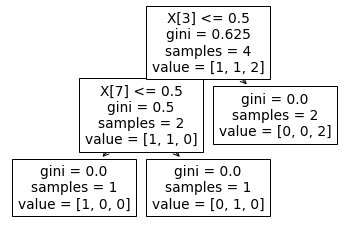

In [22]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_ohe, y_ravel)
tree.plot_tree(clf)
print(clf.predict(X_ohe[0:X.shape[0]]))
print(clf.predict(X_predict))

In [23]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_ohe, y_ravel)
MultinomialNB()
print(clf.predict(X_ohe[0:X.shape[0]]))
print(clf.predict(X_predict))

['Pass Water' 'Pass Water' 'Pass Juice' 'Pass Coke']
['Pass Coke']


In [24]:
from sklearn.naive_bayes import CategoricalNB

clf = CategoricalNB()
clf.fit(X_ohe, y_ravel)
MultinomialNB()
print(clf.predict(X_ohe[0:X.shape[0]]))
print(clf.predict(X_predict))

['Pass Water' 'Pass Water' 'Pass Juice' 'Pass Coke']
['Pass Coke']


### Healthy Unknown, depth = 3, width = 1

In [25]:
semantic_memory = init_semantic_memory(3, 1)

In [26]:
# Interaction 005 Unrecognizible: I am healthy, what would you offer?

health = Health("Node_003", "Healthy")
semantic_memory.recognize(health)

X, y = semantic_memory.extract()
print(semantic_memory)

semantic_memory.finish_cycle()

Nodes: 
  -Worker node named Mark with id Node_001 connected with Node_002 connected with Node_003 connected with Node_004.
  -Drink node named Coke with sweet taste, 4 price and in can container with id Node_002 connected with Node_001 connected with Action_01.
  -Health condition with Healthy state  connected with Node_001  connected with Node_005 . [Activated]
  -Drink node named Juice with sweet taste, 2 price and in bootle container with id Node_004 connected with Node_001 connected with Action_02.
  -Worker node named Susan with id Node_005 connected with Node_006 connected with Node_003.
  -Drink node named Water with neutral taste, 2 price and in bootle container with id Node_006 connected with Node_005 connected with Action_03 connected with Node_007.
  -Worker node named Martin with id Node_007 connected with Node_006 connected with Node_008.
  -Health condition with Diabetic state  connected with Node_007 .
Interactions: 
  -Interaction interaction_001 from Node_001 to Node_

In [27]:
X

name    taste price container   health
interaction_003   Susan  neutral     2    bootle  Healthy
interaction_001    Mark    sweet     4       can  Healthy
interaction_002    Mark    sweet     2    bootle  Healthy
interaction_004  Martin  neutral     2    bootle  DEFAULT

In [28]:
y

action
interaction_003  Pass Water
interaction_001   Pass Coke
interaction_002  Pass Juice
interaction_004  Pass Water

In [29]:
X_ohe, y_ravel, X_ohe_df = ohe(X, y)
X_ohe_df

name_Mark  name_Martin  name_Susan  taste_neutral  taste_sweet  price_2  \
0        0.0          0.0         1.0            1.0          0.0      1.0   
1        1.0          0.0         0.0            0.0          1.0      0.0   
2        1.0          0.0         0.0            0.0          1.0      1.0   
3        0.0          1.0         0.0            1.0          0.0      1.0   

   price_4  container_bootle  container_can  health_DEFAULT  health_Healthy  
0      0.0               1.0            0.0             0.0             1.0  
1      1.0               0.0            1.0             0.0             1.0  
2      0.0               1.0            0.0             0.0             1.0  
3      0.0               1.0            0.0             1.0             0.0

In [30]:
X_predict = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

['Pass Water' 'Pass Coke' 'Pass Juice' 'Pass Water']
['Pass Coke']


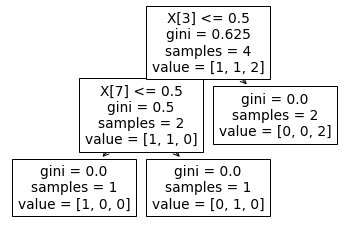

In [31]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_ohe, y_ravel)
tree.plot_tree(clf)
print(clf.predict(X_ohe[0:X.shape[0]]))
print(clf.predict(X_predict))

In [32]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_ohe, y_ravel)
MultinomialNB()
print(clf.predict(X_ohe[0:X.shape[0]]))
print(clf.predict(X_predict))

['Pass Water' 'Pass Coke' 'Pass Juice' 'Pass Water']
['Pass Water']


In [33]:
from sklearn.naive_bayes import CategoricalNB

clf = CategoricalNB()
clf.fit(X_ohe, y_ravel)
MultinomialNB()
print(clf.predict(X_ohe[0:X.shape[0]]))
print(clf.predict(X_predict))

['Pass Water' 'Pass Coke' 'Pass Juice' 'Pass Water']
['Pass Coke']


In [ ]:
# TODO uzupelnianie wiedzy pewnej z wnioskowania
# TODO do przemyslenia, time to live wezlow? Albo width opadajacy czasowo?
# TODO add removing of column if all values in this column are DEFAULT, before making numpy array)
#             
#        if not cleaned_nodes_for_interactions:
#            return (None, None) #TODO jakos to madrzej obsluzyc...


# TODO przemyslec jeszcze raz to uzupelnianie wiedzy z wnioskowania tzn. zamiast uzupelniac semantic memory, moze
#      zrobmy tak, ze dla roznych podzbiorow naszego semantic memory przychowujemy zestawy regul i dopiero gdy
#      te zestawy dla wskazanych nodeow wydaja sie nie dzialac, uruchamiamy douczanie...